# Projet 7 : Détecter les bads buzz grâce au Deep Learning - Air Paradis

- Problématique : Air Paradis a besoin de détecter les mauvais tweet afin de pouvoir agir rapidement.

Il faut ainsi développer un produit IA en utilisant 3 approches : 
- approche “API sur étagère” en utilisant l’API du service cognitif proposé par Microsoft Azure pour l’analyse de sentiment sur un échantillon des données
- approche “Modèle sur mesure simple” en utilisant le Concepteur / Designer d’un service Azure Machine Learning, interface graphique drag & drop, pour développer rapidement un modèle classique (ex : régression logistique) permettant de prédire le sentiment associé à un tweet.
- approche “Modèle sur mesure avancé” en utilisant le service Azure Machine Learning pour développer un modèle basé sur des réseaux de neurones profonds pour prédire le sentiment associé à un tweet qui sera présenté à Air Paradis

Les données utilisées sont des données opensource provenant de ce lien : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip

Import des bibliothèques

In [275]:
import random
import os
# notre package de fonctionnalités
from Package import Scripts_Analyse01 as pk
from Package import Scripts_AnalyseMulti01 as pk_multi
from Package import Scripts_AnalyseMulti02_Unsupervised as pk_multi_unsp
from Package import Scripts_AnalyseMulti02_Supervised as pk_multi_sup
from IPython.core.display import display, HTML
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from umap import UMAP
from scipy.stats import pearsonr
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.features import ParallelCoordinates
from plotly.graph_objects import Layout
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.features import PCA as PCA_yellow
from yellowbrick.style import set_palette
from sklearn import metrics
from gensim.models.ldamodel import LdaModel
from  sklearn.feature_extraction.text  import CountVectorizer 
from sklearn.decomposition import SparsePCA
import gc
import time
from contextlib import contextmanager
from sklearn import cluster
import warnings
from dotenv import load_dotenv
import re
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from wordcloud import WordCloud
from unidecode import unidecode
from sklearn import metrics
from sklearn import manifold, decomposition
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from nltk.stem.snowball import SnowballStemmer
from spacy.language import Language
import spacy
from spacymoji import Emoji
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from functools import partial
from gensim.models import FastText  
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext pycodestyle_magic


The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [273]:
from tqdm import tqdm,notebook
notebook.tqdm().pandas()

0it [00:00, ?it/s]

In [274]:
load_dotenv()

Python-dotenv could not parse statement starting at line 1


True

## Collecte des données

### Import des données

In [156]:
df = pd.read_csv('input/base.csv', encoding='latin-1', header=None)

In [157]:
df.shape

(1600000, 6)

In [158]:
df.head(2)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [159]:
df = df.drop([3], axis=1)

In [160]:
df.head(2)

,0,1,2,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...


In [161]:
df.columns = ["target", "identity", "date", "username", "tweet"]

In [162]:
df.shape

(1600000, 5)

In [163]:
df.head(2)

,target,identity,date,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...


#### Nous conservons uniquement les classes positives et négatives 

In [164]:
part1 = df.loc[df["target"]==0]

In [165]:
part1 = part1.sample(800)

In [166]:
part2 = df.loc[df["target"]==4]

In [167]:
part2 = part2.sample(800)

In [168]:
df = pd.concat([part1, part2])

In [169]:
df.shape

(1600, 5)

### Export csv

In [170]:
df.to_csv("output/sample.csv")

In [171]:
df = pd.read_csv("output/sample.csv")

In [172]:
del df["Unnamed: 0"]

## Construction de la base de données

## Pré-traitement des données

Vérification des doublons

In [173]:
sum(df.duplicated())

0

In [174]:
df.head(2)

,target,identity,date,username,tweet
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good"


Vérification des données manquantes

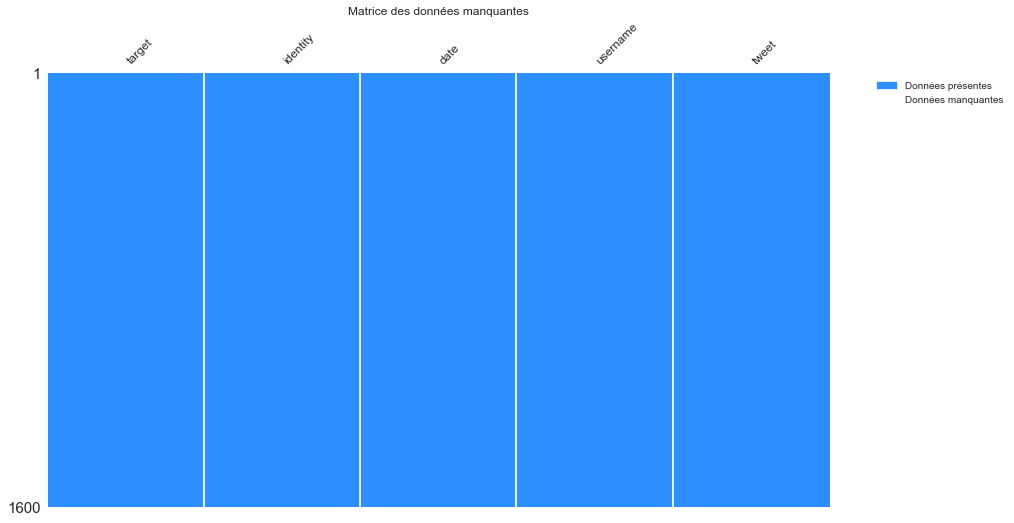

In [175]:
pk.matrix_vm(df, (14,8), (0.18, 0.56, 1))

Aucune donnée manquante

Passons au traitement du texte

In [176]:
df.head(2)

,target,identity,date,username,tweet
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good"


Regardons le nombre de texte en fonction de la variable "TARGET"  qui représente la polarité du tweet (0 = negative, 2 = neutral et 4 = positive)

Avant créons une variable avec les libellées pour améliorer la lisibilité

In [177]:
def lib_polarite_target(target):
    if target == 0:
        return "Negative"
    elif target == 2:
        return "Neutral"
    elif target == 4:
        return "Positive"

df["target_lib"] = df["target"].progress_apply(lambda x: lib_polarite_target(x))

  0%|          | 0/1600 [00:00<?, ?it/s]

In [178]:
df.head(5)

,target,identity,date,username,tweet,target_lib
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative
2,0,2064059763,Sun Jun 07 05:05:10 PDT 2009,ohglorymegan,Emily thought it'd be cool to just take my bla...,Negative
3,0,2217050969,Wed Jun 17 20:19:28 PDT 2009,brojoghost,@BlizzardSkies nothing will ever help Iran. We...,Negative
4,0,2265139701,Sun Jun 21 05:53:13 PDT 2009,itsamishmash,"drunk, and missing one of my best friends wedd...",Negative


Etudions notre variable

In [179]:
def graph_circle(data, column, title):
    """
    Graphique circulaire
    Args:
        data ([type]): données de la colonne à representer
        column ([type]): nom de la colonne
        title ([type]): titre du graphique
    Exemple:
    graph_circle(data["libelle_francais"], "libelle_francais",
                 "Répartition des arbres en fonction de leur appellation")
    """
    t = pd.crosstab(data, "freq", normalize=True)
    t = t.assign(column=t.index, freq=100 * t.freq)
    plt.figure(figsize=(18, 8))
    plt.pie(t.freq, labels=t.column,  autopct='%.0f%%')

    plt.title(title)
    my_circle = plt.Circle((0, 0), 0.4, color='white')
    p = plt.gcf()
    p.gca().add_artist(my_circle)

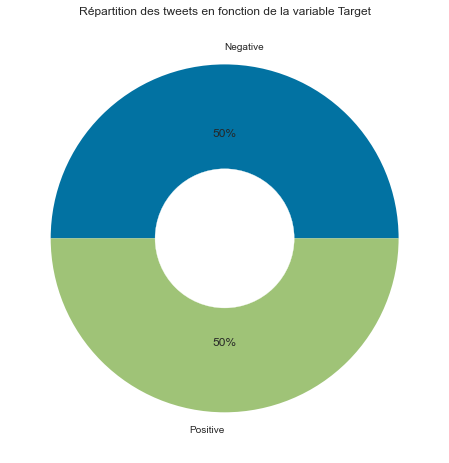

In [180]:
graph_circle(df["target_lib"], "Target",
                 "Répartition des tweets en fonction de la variable Target")

Nous observons que notre variable cible est à peu près équilibrée. En effet, nous retrouvons 57% de tweets avec un sentiment positif, contre 43% avec un sentiment negatif.

Traçons un wordcloud par classe même si le texte n'est pas encore nettoyé

In [181]:
gc.collect()

13697

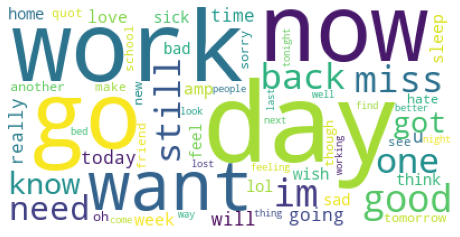

In [182]:
pk.wordcloud_plot(df.loc[df["target"]==0]["tweet"])

Nous avons ici des mots plutôt négatifs avec oh, never, horrible, burnt, byye, sorry, work, go.

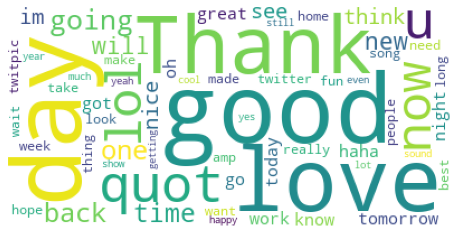

In [183]:
pk.wordcloud_plot(df.loc[df["target"]==4]["tweet"])

Nous retrouvons des mots positifs avec thank, good, well, yeah, love...

### Passons au nettoyage et à l'analyse de la variable "tweet"

In [184]:
df.head(2)

,target,identity,date,username,tweet,target_lib
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative


In [185]:
df["tweet"][0]

"@drallenlubell do know anything about sphincter of oddi dysfunction? If so, can you pls send me a link? Dx'd but unable to do ERCP "

Nous observons que des tweets mélangent majuscule et minuscule. Nous allons donc mettre le texte en minuscule. Notons aussi que nous observons un @. Il faudra donc supprimer la ponctuation.

Pour cela, nous allons utiliser spacy. Et créer un pipeline que nous complèterons au fur et à mesure afin d'avoir un texte nettoyé.
Nous mettrons donc par la suite notre texte en minuscule et nous supprimerons la ponctuation.

Nous savons que dans les tweets, nous pouvons trouver : 
- des emoticônes et des emojicônes
- des mentions (ex : @toto)
- des hashtags (ex #toureiffel)
- des reponses directes à d'autres tweets, qui seront notées avec "RE"
- des emails
- des urls

En conséquence, nous devons retranscrire les emojicônes/emoticônes car ils expriments un sentiment. 
Et il nous faut supprimer les autres éléments qui n'apportent pas forcément d'informations sur le sentiment du tweet, excepté pour les hashtags qui peuvent exprimer des sentiments tel que #encolere

Commençons par ajouter au pipeline l'identification des emoticônes et des emojicônes en premier

Pour rappel, dans le pipeline de spacy nous avons !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [186]:
nlp = spacy.load("en_core_web_sm")
_ = nlp.add_pipe("emoji", first=True)

In [187]:
nlp.pipe_names

['emoji',
 'tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [188]:
gc.collect()

10916

Nous avons bien ajouté emoji en premier. Vérifions que cela fonctionne avec un texte

In [189]:
doc = nlp("Dr. Alex Smith :-) 😂 chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")
print([(token.text, token._.is_emoji) for token in doc])

[('Dr.', False), ('Alex', False), ('Smith', False), (':-)', False), ('😂', True), ('chaired', False), ('LMAO', False), ('first', False), ('board', False), ('meeting', False), ('of', False), ('Acme', False), ('Corp', False), ('Inc.', False), ('titi@gmail.com', False), ('<', False), ('https://t.co', False), ('>', False), ('Re', False)]


Notre emojicône est bien détectée contrairement à l'emoticône. Il nous faudra donc ajouter une autre méthode.
Vérifions si nous pouvons détecter les url, les e-mails et la ponctuation.

!!!!!!!!!!!!!!!!!!!! problem ROFL | LOL | LMAO + :) :(

In [190]:
print([(token.text,token.is_punct, token._.is_emoji, token._.emoji_desc, token.like_email, token.is_stop) for token in doc])

[('Dr.', False, False, None, False, False), ('Alex', False, False, None, False, False), ('Smith', False, False, None, False, False), (':-)', True, False, None, False, False), ('😂', False, True, 'face with tears of joy', False, False), ('chaired', False, False, None, False, False), ('LMAO', False, False, None, False, False), ('first', False, False, None, False, True), ('board', False, False, None, False, False), ('meeting', False, False, None, False, False), ('of', False, False, None, False, True), ('Acme', False, False, None, False, False), ('Corp', False, False, None, False, False), ('Inc.', False, False, None, False, False), ('titi@gmail.com', False, False, None, True, False), ('<', False, False, None, False, False), ('https://t.co', False, False, None, False, False), ('>', False, False, None, False, False), ('Re', False, False, None, False, True)]


Nous détectons bien ces informations.

Ajoutons "RE" dans les stopwords qui apparait lors de la réponse direct à un tweet

Voici un extrait de la liste des stopwords.

In [475]:
import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words

print(len(stopwords))
print(stopwords)

326
{'yourselves', 'alone', 'around', 'hereupon', 'amongst', 'everyone', '’ve', 'while', 'her', 'only', 'yourself', 'will', 'therein', 'whence', 'keep', 'just', 'become', 'were', 'be', 'n’t', 'twenty', 'towards', 'thereupon', 'these', 'some', 'back', 'show', 'behind', 'into', 'six', 'someone', "'ve", 'twelve', '’m', 'still', 'would', 'whom', 'which', 'call', 'this', 'ever', 'without', 'per', 'himself', 'anyone', 'eight', 'also', 'its', 'them', 'did', 'no', 'your', 'own', 'any', 'thereafter', 'was', 'they', 'whereupon', 'whole', 'yet', 'could', 'nobody', 'ours', 'almost', 'thence', 'where', 'on', 'before', 'front', 'if', 'such', 'get', 'wherever', 'beyond', 'unless', 'under', 'eleven', 'nor', 'since', "'re", 'various', 'becomes', 'anything', 'should', 'thus', 'otherwise', 'ourselves', 'and', 'my', 'other', 'about', 'might', 'by', 'very', 'herein', 'through', 'wherein', 'n‘t', 'thru', 'seems', '‘re', 'always', 'noone', 'it', 'most', 'itself', 'though', 'below', '‘d', 'amount', 'same', "n

In [192]:
nlp.Defaults.stop_words.add("re")

In [478]:
nlp.Defaults.stop_words -= {"not", "no", "n't", "would", "without", "could", "still", "ever", 
                            "yet", "almost", "should", "always", "too", "sometimes", "except", 
                            "everything", "really", "nothing", "down", "also", "very", "most", "'d", 
                            "serious", "than", "however", "well", "neither", "anyhow", "few",
                            "rather", "mostly", "none", "must", "less", "many", "as", "often", 
                            "never", "enough", "much", "out", "but", "whereas", "netherrless",
                            "next", "even", "although", "why", "again", "perhaps"}

In [193]:
print([(token.text,token.is_punct, token._.is_emoji, token._.emoji_desc, token.like_email, token.is_stop) for token in doc])

[('Dr.', False, False, None, False, False), ('Alex', False, False, None, False, False), ('Smith', False, False, None, False, False), (':-)', True, False, None, False, False), ('😂', False, True, 'face with tears of joy', False, False), ('chaired', False, False, None, False, False), ('LMAO', False, False, None, False, False), ('first', False, False, None, False, True), ('board', False, False, None, False, False), ('meeting', False, False, None, False, False), ('of', False, False, None, False, True), ('Acme', False, False, None, False, False), ('Corp', False, False, None, False, False), ('Inc.', False, False, None, False, False), ('titi@gmail.com', False, False, None, True, False), ('<', False, False, None, False, False), ('https://t.co', False, False, None, False, False), ('>', False, False, None, False, False), ('Re', False, False, None, False, True)]


"Re" est donc bien détecté comme un stopword.

Créons une fonction pour détecter les mentions dans les tweets (ex: @toto)

In [479]:
from spacy.tokens import Token

# Définit l'extension sur le Token avec une valeur par défaut
#Token.set_extension("is_mention", default=False)

def is_mention_function(token):
    if token.text.startswith("@") == True and len(token.text)>1:
        return True
        
Token.set_extension("is_mention", getter=is_mention_function, force=True)

In [195]:
doc = nlp("I have @toto")
for token in doc:
    if token._.is_mention == True:
        print(token._.is_mention)

True


La mention est bien détectée

Nous pouvons donc créer un nouveau composant qui permettra d'obtenir nos mots nettoyés

In [196]:
# Définit un composant personnalisé
def text_clean_function(doc):
    new_words = []
    for token in doc:
        if token._.is_emoji:
            if token._.emoji_desc != " ":
                new_words.append(token._.emoji_desc)
            else:
                continue
        elif token.like_email or token.is_stop or token.like_url:
            continue
        elif token._.is_mention == True:
            continue
        elif token.is_punct:
            continue
        else :
            if token.text.strip() != "":
                new_words.append(token.text)
    return new_words


In [197]:
from spacy.tokens import Doc

@Language.component("pre_process_text")
def pre_process_text_function(doc):
    # Generate a new list of tokens here
    new_words = text_clean_function(doc)
    new_doc = Doc(doc.vocab, words=new_words)
    return new_doc

In [198]:
# Ajoute le composant en premier dans le pipeline
nlp.add_pipe("pre_process_text", before="tok2vec")

<function __main__.pre_process_text_function(doc)>

In [199]:
nlp.pipe_names

['emoji',
 'pre_process_text',
 'tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [200]:
doc = nlp("Dr. Alex Smith :-) 😂 @toto chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")


In [201]:
def stemming_function(doc):
    stemmer = SnowballStemmer(language='english')
    list_doc = []
    for token in doc:
        print(token.text)
        list_doc.append(stemmer.stem(token.text))
    return list_doc

In [202]:
test = stemming_function(doc)

Dr.
Alex
Smith
face with tears of joy
chaired
LMAO
board
meeting
Acme
Corp
Inc.
<
>


In [203]:
doc.text

'Dr. Alex Smith face with tears of joy chaired LMAO board meeting Acme Corp Inc. < > '

In [204]:
test

['dr.',
 'alex',
 'smith',
 'face with tears of joy',
 'chair',
 'lmao',
 'board',
 'meet',
 'acm',
 'corp',
 'inc.',
 '<',
 '>']

In [205]:
from spacy.tokens import Token

# Définit l'extension sur le Token avec une valeur par défaut
#Token.set_extension("is_mention", default=False)
def stemming_function(token):
    stemmer = SnowballStemmer(language='english')
    stem = stemmer.stem(token.text)
    return stem

Token.set_extension("stemming_", getter=stemming_function, force=True)

In [206]:
doc = nlp("Dr. Alex Smith :-) 😂 @toto chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")


In [207]:
for token in doc:
    print(token._.stemming_)

dr.
alex
smith
face with tears of joy
chair
lmao
board
meet
acm
corp
inc.
<
>


In [208]:
df["tweet_clean"] = df["tweet"].progress_apply(lambda x: nlp(x))

  0%|          | 0/1600 [00:00<?, ?it/s]

In [480]:
df["tweet_lemma"] = df["tweet"].progress_apply(lambda x: [token.lemma_ for token in nlp(x)])

  0%|          | 0/1584 [00:00<?, ?it/s]

In [481]:
df["tweet_stem"] = df["tweet"].progress_apply(lambda x: [token._.stemming_ for token in nlp(x)])

  0%|          | 0/1584 [00:00<?, ?it/s]

In [482]:
df.head(2)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join,vector,cg_positive,cg_neutral,cg_negative,target_new
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[@drallenlubell, do, know, anything, about, sp...","[@drallenlubel, do, know, anyth, about, sphinc...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...,"[[-0.026022, 0.049334332, -0.07136642, 0.02925...",0.01,0.05,0.94,0
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[its, not, lookin, good, Mr., Sun, ,, its, not...","[it, not, lookin, good, mr., sun, ,, it, not, ...",lookin good Mr. Sun lookin good,lookin good mr. sun lookin good,"[[-0.01793317, 0.033346422, -0.044616614, 0.01...",0.99,0.01,0.00,0


Nous ne supprimons pas les # car on peut avoir des #encolere

In [212]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)


pattern =  [{'ORTH': '#'}, {'IS_ASCII': True}]
matcher.add('HASHTAG', [pattern])

doc = nlp("Hello, world! Hello world! ###toto")
matches = matcher(doc)
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print( string_id, start, end, span.text)

    

HASHTAG 7 9 ##
HASHTAG 8 10 ##
HASHTAG 9 11 #toto


In [213]:
df.head(3)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l..."
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[lookin, good, Mr., Sun, lookin, good]","[lookin, good, mr., sun, lookin, good]"
2,0,2064059763,Sun Jun 07 05:05:10 PDT 2009,ohglorymegan,Emily thought it'd be cool to just take my bla...,Negative,"(Emily, thought, cool, blanket, pillow, come, ...","[Emily, think, cool, blanket, pillow, come, help]","[emili, thought, cool, blanket, pillow, come, ..."


In [214]:
gc.collect()

8604

#### !!!!!!!!!!!!retraçons les wordcloud par classe et par methode stem / lemma

In [483]:
df["tweet_lemma_join"] = df["tweet_lemma"].progress_apply(lambda x: " ".join(x))

  0%|          | 0/1584 [00:00<?, ?it/s]

In [484]:
df["tweet_stem_join"] = df["tweet_stem"].progress_apply(lambda x: " ".join(x))

  0%|          | 0/1584 [00:00<?, ?it/s]

In [217]:
df.head(2)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[lookin, good, Mr., Sun, lookin, good]","[lookin, good, mr., sun, lookin, good]",lookin good Mr. Sun lookin good,lookin good mr. sun lookin good


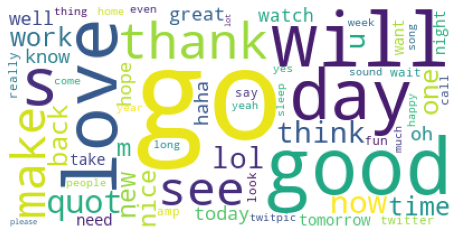

In [486]:
pk.wordcloud_plot(df.loc[df["target"]==1]["tweet_lemma_join"])

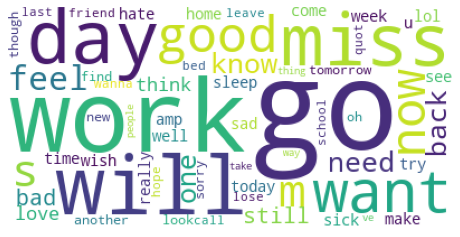

In [487]:
pk.wordcloud_plot(df.loc[df["target"]==0]["tweet_lemma_join"])

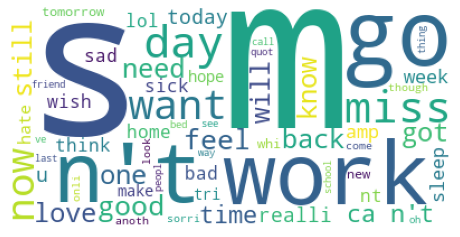

In [488]:
pk.wordcloud_plot(df.loc[df["target"]==0]["tweet_stem_join"])

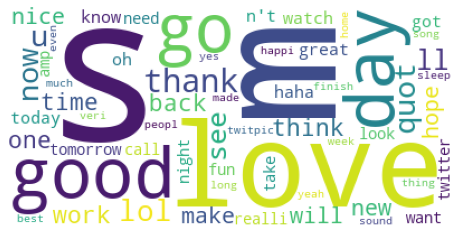

In [490]:
pk.wordcloud_plot(df.loc[df["target"]==1]["tweet_stem_join"])

Nous conservons donc la méthode de lemmatisation. Nous pouvons supprimer les colonnes contenant les données de stemming.

In [ ]:
df.drop(["tweet_stem", "tweet_stem_join"], axis=1)

La technique de lemmatization supprime surement des commentaires qui n'ont pas de sens tel que "I will go".
Nous supprimons donc les lignes vides.

In [222]:
df = df.loc[df["tweet_lemma"] != np.array(0)]

In [223]:
df.shape

(1584, 11)

In [ ]:
graph_circle(df["target_lib"], "Target",
                 "Répartition des tweets en fonction de la variable Target")

## Feature engineering

Deux méthodes : Glove, Fasttext

### Commençons par Glove

- Algorithme pour l'incorporation de mots :
- Prétraitez les données textuelles.
- Créé le dictionnaire.
- Parcourir le fichier glove d'une dimension précise et comparer chaque mot avec tous les mots du dictionnaire,
- si une correspondance se produit, copiez le vecteur équivalent du gant et collez-le dans embedding_matrix à l'index correspondant.

In [224]:
df.head(2)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[lookin, good, Mr., Sun, lookin, good]","[lookin, good, mr., sun, lookin, good]",lookin good Mr. Sun lookin good,lookin good mr. sun lookin good


In [225]:
df["tweet_lemma"][0]

['know',
 'sphincter',
 'oddi',
 'dysfunction',
 'pls',
 'send',
 'link',
 "Dx'd",
 'unable',
 'ERCP']

In [226]:
# Change the current working directory
os.chdir(r'D:Users\Aurel\OneDrive_N\OneDrive\_WORK0\IngenieurIA\projets\Projet7BadBuzz\OP_Project7')

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'D:Users\\Aurel\\OneDrive_N\\OneDrive\\_WORK0\\IngenieurIA\\projets\\Projet7BadBuzz\\OP_Project7'

In [227]:
emmbed_dict = {}
with open('Input/glove.6B/glove.6B.200d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector

In [228]:
# code for Glove word embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
  
x = df["tweet_lemma"]
  
# create the dict.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

In [229]:
# number of unique words in dict.
print("Number of unique words in dictionary=", 
      len(tokenizer.word_index))
print("Dictionary is = ", tokenizer.word_index)
  
# download glove and unzip it in Notebook.
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip
  
# vocab: 'the': 1, mapping of words with
# integers in seq. 1,2,3..
# embedding: 1->dense vector
def embedding_for_vocab(filepath, word_index,
                        embedding_dim):
    vocab_size = len(word_index) + 1
      
    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size,
                                       embedding_dim))
  
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
  
    return embedding_matrix_vocab
  
  
# matrix for vocab: word_index
embedding_dim = 50
path = r'input/glove.6B/glove.6B.50d.txt'
embedding_matrix_vocab = embedding_for_vocab(
    path, tokenizer.word_index,
  embedding_dim)
  
print("Dense vector for first word is => ",
      embedding_matrix_vocab[1])

Number of unique words in dictionary= 3664
Dictionary is =  {'good': 1, 'day': 2, 'go': 3, 'like': 4, 'work': 5, 'love': 6, 'get': 7, 'want': 8, 'think': 9, 'm': 10, 'lol': 11, 'not': 12, 'know': 13, 'time': 14, 'today': 15, 'miss': 16, 'need': 17, 'thank': 18, 'u': 19, 'night': 20, 'look': 21, 'new': 22, 'feel': 23, 'week': 24, 'sleep': 25, 'tomorrow': 26, 'oh': 27, 'home': 28, 'bad': 29, 'come': 30, 'hope': 31, 'amp': 32, 'try': 33, 'nice': 34, '2': 35, 'haha': 36, 'watch': 37, 'thing': 38, 'great': 39, 'to': 40, 'twitter': 41, 'people': 42, 'wish': 43, 'morning': 44, 'wait': 45, 'bed': 46, 'right': 47, 'sad': 48, 'happy': 49, '3': 50, 'friend': 51, 'hate': 52, 'long': 53, 'find': 54, 'well': 55, 'yeah': 56, 'sick': 57, 'way': 58, 'see': 59, 'tonight': 60, 'leave': 61, 'wanna': 62, 'cool': 63, 'sound': 64, 'make': 65, 'year': 66, 'sorry': 67, 'school': 68, '4': 69, 'fun': 70, 'life': 71, 'yes': 72, 'early': 73, 'little': 74, 'win': 75, 's': 76, 'old': 77, 'start': 78, 'hour': 79, 'lo

In [230]:
embedding_matrix_vocab

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.35585999,  0.52130002, -0.61070001, ...,  0.27206999,
         0.31305   ,  0.92771   ],
       [ 0.11626   ,  0.53896999, -0.39513999, ..., -0.39061999,
        -0.10885   ,  0.084513  ],
       ...,
       [-0.94415998, -0.30311999, -0.20235001, ..., -1.05350006,
         0.58445001,  0.71354002],
       [ 0.45144999,  0.31307   , -1.5711    , ..., -0.39265999,
        -0.28088   ,  0.059961  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [231]:
embedding_matrix_vocab

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.35585999,  0.52130002, -0.61070001, ...,  0.27206999,
         0.31305   ,  0.92771   ],
       [ 0.11626   ,  0.53896999, -0.39513999, ..., -0.39061999,
        -0.10885   ,  0.084513  ],
       ...,
       [-0.94415998, -0.30311999, -0.20235001, ..., -1.05350006,
         0.58445001,  0.71354002],
       [ 0.45144999,  0.31307   , -1.5711    , ..., -0.39265999,
        -0.28088   ,  0.059961  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [232]:
import spacy
nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

unique_words = list(set([word for sublist in tokenized_corpus for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
vec_df = pd.DataFrame(word_glove_vectors, index=unique_words)
vec_df

OSError: [E050] Can't find model 'en_vectors_web_lg'. It doesn't seem to be a Python package or a valid path to a data directory.

### Passons à Fasttext

In [234]:
df["tweet_lemma"][0]

['know',
 'sphincter',
 'oddi',
 'dysfunction',
 'pls',
 'send',
 'link',
 "Dx'd",
 'unable',
 'ERCP']

In [237]:
# Defining values for parameters
embedding_size = 300
window_size = 5
min_word = 5
#down_sampling = 1e-2
 
fast_Text_model = FastText(df["tweet_lemma"],
                      window=window_size,
                      min_count=min_word,
                      #sample=down_sampling,
                      workers = 4,
                      sg=1)

In [238]:
fast_Text_model.wv["happy"]

array([-3.33023183e-02,  6.33239597e-02, -9.07067806e-02,  3.30830030e-02,
       -1.24760598e-01, -1.00191049e-01,  3.67681012e-02,  1.15906797e-01,
       -3.76115255e-02, -5.38650341e-02,  3.73960808e-02, -1.08264960e-01,
       -1.01745557e-02,  1.87042311e-01,  1.64011568e-01,  5.15860855e-04,
        1.64632462e-02, -4.66103926e-02, -7.18537122e-02, -2.34034315e-01,
       -2.13403419e-01, -1.54782680e-03, -6.94217384e-02, -9.77654085e-02,
       -1.00386113e-01, -6.13764115e-03, -2.71146335e-02, -6.55594319e-02,
        1.11730531e-01, -8.27788841e-03,  7.61053199e-03, -1.01158865e-01,
        1.46456733e-01,  8.99303798e-03, -6.37281165e-02,  1.17815949e-01,
       -2.32516378e-01,  2.88553406e-02, -1.08584166e-01, -1.60702448e-02,
       -4.72039096e-02, -1.25913650e-01, -8.10174923e-03, -1.57607362e-01,
       -1.02648810e-01, -3.21753845e-02, -1.85163334e-01,  5.89754768e-02,
       -1.26632661e-01,  1.76671408e-02,  8.55255872e-02,  5.87211661e-02,
        9.31688100e-02,  

In [239]:
fast_Text_model.wv.most_similar(positive="best")

[('yesterday', 0.9988861680030823),
 ('today', 0.9988822340965271),
 ('home', 0.9988815784454346),
 ('amazing', 0.998867392539978),
 ('way', 0.9988619089126587),
 ('birthday', 0.9988479614257812),
 ('tonight', 0.9988471269607544),
 ('make', 0.9988466501235962),
 ('time', 0.9988448619842529),
 ('fight', 0.9988438487052917)]

In [240]:
df.shape

(1584, 11)

on va donc tokeniser le corpus et pour le mot go du premier document on va calculer les similarités avec les autres mots

In [241]:
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros((model.vector_size,))


In [242]:
df.head(2)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[lookin, good, Mr., Sun, lookin, good]","[lookin, good, mr., sun, lookin, good]",lookin good Mr. Sun lookin good,lookin good mr. sun lookin good


In [473]:

df["vector"] = df["tweet_lemma"].progress_apply(lambda x: [ get_vect(y, fast_Text_model)  for y in x])
#wv_train_feat.shape

  0%|          | 0/1584 [00:00<?, ?it/s]

In [244]:
df.head(4)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join,vector
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...,"[[-0.014301749, 0.024223123, -0.060936723, 0.0..."
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[lookin, good, Mr., Sun, lookin, good]","[lookin, good, mr., sun, lookin, good]",lookin good Mr. Sun lookin good,lookin good mr. sun lookin good,"[[-0.0050749206, 0.022323139, -0.096266314, -0..."
2,0,2064059763,Sun Jun 07 05:05:10 PDT 2009,ohglorymegan,Emily thought it'd be cool to just take my bla...,Negative,"(Emily, thought, cool, blanket, pillow, come, ...","[Emily, think, cool, blanket, pillow, come, help]","[emili, thought, cool, blanket, pillow, come, ...",Emily think cool blanket pillow come help,emili thought cool blanket pillow come help,"[[-0.021717677, 0.04667895, -0.08812917, 0.003..."
3,0,2217050969,Wed Jun 17 20:19:28 PDT 2009,brojoghost,@BlizzardSkies nothing will ever help Iran. We...,Negative,"(help, Iran, giving, illusion, helping, Iran)","[help, Iran, give, illusion, help, Iran]","[help, iran, give, illus, help, iran]",help Iran give illusion help Iran,help iran give illus help iran,"[[-0.0027670534, -0.02425949, 0.00024292432, -..."


In [472]:
df["vector"][0]

[array([-0.01430175,  0.02422312, -0.06093672,  0.00040992, -0.04547247,
        -0.05197418,  0.00300965,  0.04797696, -0.00303858, -0.03699137,
        -0.0017968 , -0.04091725, -0.00763484,  0.0825133 ,  0.08552602,
         0.00536112,  0.00313383, -0.02715887, -0.03679474, -0.11655396,
        -0.10185711, -0.0170428 , -0.03051149, -0.05244933, -0.05037827,
        -0.01916718, -0.02036944, -0.02471073,  0.03337831, -0.00620595,
         0.01058172, -0.0360789 ,  0.06123185,  0.00255992, -0.03330677,
         0.05180888, -0.10962382,  0.00832439, -0.06109658, -0.02975165,
        -0.04500129, -0.04770095, -0.00596935, -0.0798346 , -0.04804855,
        -0.03326777, -0.07694391,  0.03629438, -0.05365432,  0.00873409,
         0.05510378,  0.03288009,  0.03939836,  0.04643906, -0.00615343,
        -0.0694351 ,  0.04927641, -0.05650795, -0.03930229,  0.06574233,
         0.0989922 ,  0.02038537, -0.03263411,  0.04458078, -0.02618312,
         0.01965605,  0.01538406, -0.01057338,  0.0

FastText applique déjà une réduction de données, on ne fait donc pas d'ACP.

## Modèle avancé

### Réseau de neurone simple

In [454]:
model = Sequential()
model.add(LSTM(8,input_shape=(1108,1),return_sequences=True))#True = many to many
model.add(Dense(2,kernel_initializer='normal',activation='relu'))
model.add(Dense(1,kernel_initializer='normal',activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(loss='mse',optimizer ='adam',metrics=['auc'])

In [455]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 1108, 1) <dtype: 'float32'>
(None, 1108, 2) <dtype: 'float32'>
lstm_9 (None, 1108, 1) float32
dense_26 (None, 1108, 8) float32
dense_27 (None, 1108, 2) float32
dense_28 (None, 1108, 1) float32


[None, None, None, None]

In [460]:
def ml_pipeline_divide_data(df):
    data=df.copy()
    data2=data.copy()
    
    X=data2[["vector"]].loc[data["target"].notnull()]
    del data2["target"]
    Y=data["target"].loc[data["target"].notnull()]
    return X,Y

In [467]:
def ml_step1_ech(df):
    X, Y = ml_pipeline_divide_data(df)
    X_train, X_test, y_train, y_test = pk_multi_sup.pipelineModel_TrainingSet(X, Y, 0, 0.3)
    return X_train, X_test, y_train, y_test

In [468]:
X_train.shape

(1108, 1)

In [469]:
X_train, X_test, y_train, y_test = ml_step1_ech(df)

In [470]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=120,batch_size=64)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [ ]:
results = model.evaluate(X_test,y_test)

In [ ]:
y_pred = model.predict(embedded_docs_pred)

## Service cognitif Azure : Analyse de sentiment

KEYS IN KEYVUALT OR UMI

In [ ]:
from azure.identity import DefaultAzureCredential
from azure.keyvault.keys import KeyClient

credential = DefaultAzureCredential()

key_client = KeyClient(vault_url="https://my-key-vault.vault.azure.net/", credential=credential)
key = key_client.get_key("key-name")
print(key.name)

In [252]:
#################key vault

cog_key = os.getenv('cog_key')
cog_endpoint = os.getenv('cog_endpoint')

#print('Ready to use cognitive services at {} using key {}'.format(cog_endpoint, cog_key))


In [251]:
import os
from azure.ai.textanalytics import TextAnalyticsClient

from azure.cognitiveservices.language.textanalytics import TextAnalyticsClient
from msrest.authentication import CognitiveServicesCredentials

# Get a client for your text analytics cognitive service resource
text_analytics_client = TextAnalyticsClient(endpoint=cog_endpoint,
                                            credentials=CognitiveServicesCredentials(cog_key))


In [250]:
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

# Authenticate the client using your key and endpoint 
def authenticate_client():
    ta_credential = AzureKeyCredential(cog_key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=cog_endpoint, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

In [253]:
def azure_cg(text, score):
    documents = []
    documents.append(text)
    response = client.analyze_sentiment(documents=documents)[0]
    if score == 1:
        return response.confidence_scores.positive
    elif score == 2:
        return response.confidence_scores.neutral
    elif score == 3:
        return response.confidence_scores.negative

In [254]:
df.head(2)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join,vector
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...,"[[-0.014301749, 0.024223123, -0.060936723, 0.0..."
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[lookin, good, Mr., Sun, lookin, good]","[lookin, good, mr., sun, lookin, good]",lookin good Mr. Sun lookin good,lookin good mr. sun lookin good,"[[-0.0050749206, 0.022323139, -0.096266314, -0..."


In [491]:
df["cg_positive"] = df["tweet_lemma_join"].progress_apply(lambda x: azure_cg(x, 1))

  0%|          | 0/1584 [00:00<?, ?it/s]

In [257]:
df.head(2)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join,vector,cg_positive
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...,"[[-0.014301749, 0.024223123, -0.060936723, 0.0...",0.01
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[lookin, good, Mr., Sun, lookin, good]","[lookin, good, mr., sun, lookin, good]",lookin good Mr. Sun lookin good,lookin good mr. sun lookin good,"[[-0.0050749206, 0.022323139, -0.096266314, -0...",0.99


In [ ]:
df["cg_neutral"] = df["tweet_lemma_join"].progress_apply(lambda x: azure_cg(x, 2))

  0%|          | 0/1584 [00:00<?, ?it/s]

In [ ]:
df["cg_negative"] = df["tweet_lemma_join"].progress_apply(lambda x: azure_cg(x, 3))

  0%|          | 0/1584 [00:00<?, ?it/s]

In [378]:
df2 = df.copy().reset_index()

In [373]:
gc.collect()

38226

In [474]:
df2.head(5)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,"[-0.014301749, 0.024223123, -0.060936723, 0.00...","[-0.035943605, 0.04616728, -0.09908174, 0.0354...","[-0.009074477, 0.03113043, -0.0713251, -0.0005...","[-0.056566447, 0.11529011, -0.20659986, 0.0565...","[-0.023980137, 0.022551332, -0.060187697, 0.00...","[-0.03181378, 0.04675488, -0.078825615, 0.0295...","[0.0043587387, -0.0077401306, -0.03681741, -0....","[-0.019023212, 0.05087924, -0.05561589, 0.0267...","[-0.028621102, 0.06259232, -0.12146374, 0.0370...","[0.005962951, 0.00477709, -0.0026163342, 0.011...",...,None,None,None,None,None,None,None,None,None,None
1,"[-0.0050749206, 0.022323139, -0.096266314, -0....","[-0.028963149, 0.062637806, -0.09756238, 0.022...","[-0.007969433, 0.032314204, -0.031384252, 0.00...","[-0.03122764, 0.04533994, -0.08000016, 0.03264...","[-0.0050749206, 0.022323139, -0.096266314, -0....","[-0.028963149, 0.062637806, -0.09756238, 0.022...",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,"[-0.021717677, 0.04667895, -0.08812917, 0.0033...","[-0.007069084, -0.0012363156, -0.02936078, -0....","[0.009811481, 0.020972783, -0.07669831, 0.0053...","[-0.005891233, 0.010830505, -0.07186549, 0.016...","[0.00042996928, -0.013010739, -0.056998473, -0...","[-0.020488758, 0.062602706, -0.10734727, 0.044...","[-0.0027670534, -0.02425949, 0.00024292432, -0...",None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,"[-0.0027670534, -0.02425949, 0.00024292432, -0...","[-0.013898638, 0.024089873, -0.053928263, 0.02...","[-0.02488217, 0.007933799, -0.010346179, 0.008...","[-0.03733572, 0.08195364, -0.18087114, 0.01198...","[-0.0027670534, -0.02425949, 0.00024292432, -0...","[-0.013898638, 0.024089873, -0.053928263, 0.02...",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,"[-0.035997726, 0.09135148, -0.1303468, 0.03462...","[-0.071773544, 0.12966552, -0.17939256, 0.0626...","[-0.028963149, 0.062637806, -0.09756238, 0.022...","[-0.007889866, 0.027413577, -0.059419375, 0.01...","[-0.0072829993, 0.0062625753, -0.017197253, 0....","[-0.0034164423, -0.004783701, -0.026213065, 0....","[-0.026314942, 0.03880649, -0.06459046, 0.0157...","[-0.035997726, 0.09135148, -0.1303468, 0.03462...","[-0.005647418, 0.006160565, -0.052543793, -0.0...","[-0.02423532, 0.044220418, -0.07387471, 0.0241...",...,None,None,None,None,None,None,None,None,None,None


In [380]:
del df2["vector"]

In [381]:
df2.to_csv("output/sample_cg.csv")

In [261]:
gc.collect()

9084

In [276]:
df.head(3)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join,vector,cg_positive,cg_neutral,cg_negative
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...,"[[-0.014301749, 0.024223123, -0.060936723, 0.0...",0.01,0.05,0.94
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[lookin, good, Mr., Sun, lookin, good]","[lookin, good, mr., sun, lookin, good]",lookin good Mr. Sun lookin good,lookin good mr. sun lookin good,"[[-0.0050749206, 0.022323139, -0.096266314, -0...",0.99,0.01,0.00
2,0,2064059763,Sun Jun 07 05:05:10 PDT 2009,ohglorymegan,Emily thought it'd be cool to just take my bla...,Negative,"(Emily, thought, cool, blanket, pillow, come, ...","[Emily, think, cool, blanket, pillow, come, help]","[emili, thought, cool, blanket, pillow, come, ...",Emily think cool blanket pillow come help,emili thought cool blanket pillow come help,"[[-0.021717677, 0.04667895, -0.08812917, 0.003...",0.97,0.03,0.00


Nous modifions la valeur 4 à 1 afin que ce soit plus pratique avec l'utilisation des algorithmes. 1 = tweet positif et 0 tweet negatif

In [326]:
df2 = df.copy()

In [331]:
df['target'] = df['target'].map({0:0,
                             4:1},
                             na_action=None)

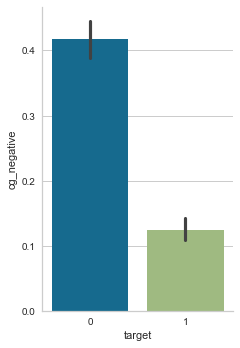

In [332]:
sns.catplot(x="target", y="cg_negative",
                data=df, kind="bar",
                 aspect=.7)

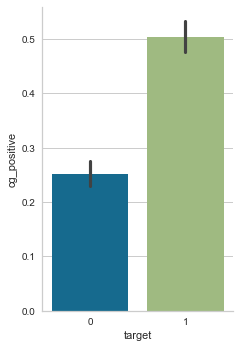

In [333]:
sns.catplot(x="target", y="cg_positive",
                data=df, kind="bar",
                 aspect=.7)



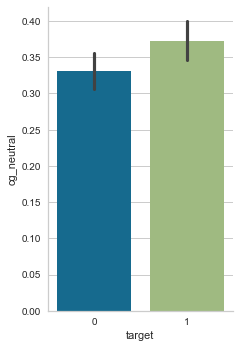

In [334]:
sns.catplot(x="target", y="cg_neutral",
                data=df, kind="bar",
                 aspect=.7)

### Modèle Simple : Regression logistique VS RandomForest

Nous séparons notre jeu de données en train et en test

In [279]:
def pipeline_divide_data(df):
    data=df.copy()
    data2=data.copy()
    X=data2[["cg_positive", "cg_neutral", "cg_negative"]].loc[data["target"].notnull()]
    del data2["target"]
    Y=data["target"].loc[data["target"].notnull()]
    return X,Y

In [337]:
X

,cg_positive,cg_neutral,cg_negative
0,0.01,0.05,0.94
1,0.99,0.01,0.00
2,0.97,0.03,0.00
3,0.83,0.09,0.08
4,0.11,0.02,0.87
...,...,...,...
1595,0.93,0.01,0.06
1596,0.98,0.02,0.01
1597,0.02,0.97,0.01
1598,0.12,0.04,0.84


Nous voulons détecter les commentaires négéatifs pour pouvoir agir. Nous allons créer une nouvelle métrique dans laquelle nous allons donc accentuer la non détection des commentaires négatifs.

Nous testons deux méthodes : Regression logistique et l'arbre de decision : Random forest

Pour cela, nous utilisons Hyperopt pour choisir les meilleures paramètres possibles

In [338]:
import mlflow
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
# fonction pour diviser le dataframe en training set
def step1_ech(df):
    X, Y = pipeline_divide_data(df)
    X_train, X_test, y_train, y_test = pk_multi_sup.pipelineModel_TrainingSet(X, Y, 0, 0.3)
    return X_train, X_test, y_train, y_test

####score pour fonction metier >> on veut detecter les commentaires negatives afin de pouvoir agir, nous accentuons donc le poids pour les Faux negatifs.
def fmetric_metier(y_true, y_pred):
    CM = metrics.confusion_matrix(y_true, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    metier = (FN*0.9+FP*0.1)/(FN+FP+TN+TP)
    
    print('FULL Métrique Métier : ', metier)
    return metier

metric_history = []
best_metric_history_n = []
feat_imp_df = pd.DataFrame()
feat_imp_df_history = []


###creation de fonction pour le tuning des hyperparamètres
def objective(params, X, y):
    gc.collect()
    print("------------------------------------------------")
    print("--------------params : ", params)
    #del params['type']
    classifier_type = params['type']
    #maxd=params['max_depthg']
    #del params['max_depthg']
    del params['type']
    
    ## Correction des paramètres identiques
    if 'max_depthg' in params:
        params["max_depth"]=int(params["max_depthg"])
        params["n_estimators"]=int(params["n_estimatorsg"])
        del params["max_depthg"]
        del params["n_estimatorsg"]
        
    if classifier_type == 'rf':
        clf = RandomForestClassifier(**params)
    elif (classifier_type == 'logreg'):
        clf = LogisticRegression(**params)
    else:
        return 0
    feat_imp_df = pd.DataFrame()

    auc_fold=[]
    metier_fold=[]
    cv = StratifiedKFold(n_splits=3)
    i=1
    t0 = time.time()
    for train_idx, test_idx, in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

                #standardisation
        std_scale = StandardScaler().fit(X_train)
        X_train = std_scale.fit_transform(X_train)
        clf.fit(X_train, y_train)  
            
        y_prob = clf.predict_proba(X_test)[:,1] 
                
        # On créé un vecteur de prédiction à partir du vecteur de probabilités
        y_pred = np.where(y_prob > 0.5, 1, 0) 
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        metier_c=fmetric_metier(y_test, y_pred)
        auc_fold.append(roc_auc)
        metier_fold.append(metier_c)
        print(f'For fold {i}:')
        print(f'AUC: {roc_auc}')
        print(f'f1-score: {metrics.f1_score(y_test, y_pred)}')
        print(f'score métier:{metier_c}')
        fold_importance_df = pd.DataFrame()
        if (classifier_type != 'logreg'):
            fold_importance_df["classifier_type"] = classifier_type
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = i + 1
            if len(feat_imp_df)>0:
                feat_imp_df = pd.concat([feat_imp_df, fold_importance_df], axis=0)
            else:
                feat_imp_df = fold_importance_df
                feat_imp_df_history.append(feat_imp_df)
        gc.collect()
        i+=1
        
    time_res=time.time() - t0
    auc_m=np.mean(auc_fold)
    metier=np.mean(metier_fold)
    print("metric auc moyenne :", auc_m)
    print("taux metier moyen :", metier)
    print("temps calcul :", time_res)

    if len(best_metric_history_n)>0:
        best_metric = max(best_metric_history_n)
    else:
        best_metric=auc_m

    print("best_metric : ", best_metric)
    if auc_m > best_metric:
        best_metric=auc_m

    metric_history.append({'classifier_type':classifier_type, 'auc':auc_m,'metier':metier, 'time':time_res, 'params':params})
    best_metric_history_n.append(best_metric)

    #Because fmin() tries to minimize the objective, this function must return the negative accuracy. 
    return {'loss': 1-auc_m, 'status': STATUS_OK}


search_space = hp.choice('classifier_type', [
    {
        'type': 'rf',
        'max_depth': hp.choice('max_depth', range(3,10)),
        'n_estimators': hp.choice('n_estimators', range(100,300)),#nb d'arbres dans la forêt
        'max_features': hp.choice('max_features', range(1, 3)),#nb de variables max pour diviser un noeud
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1,0.4), #nb de points de données placées dans un noeud avec qu'il soit divisé
        'min_samples_split': hp.choice('min_samples_split', range(2,12)) #nb minimal de points de données autorisées dans un noeud de feuille
       # 'criterion': hp.choice('criterion', ['gini', 'entropy'])
        #bootstrap > avec ou sans remplacement
    },
    {
        'type': 'logreg',
        'C': hp.uniform('LR_C', 0.1,1.0), # force de la penalité
        'solver': hp.choice('solver', ['liblinear']),#, 'lbfgs'
        'penalty' : hp.choice('penalty', ['l1','l2'])
    }
])


#Nous allons restreindre les colonnes sur la regression logistique, nous testerons les features obtenues grâce aux méthodes statistiques et celles sorties via le LGBM.
def score_model(X_train, y_train):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    scores = []
    i=0
    print("------------------------------------------")
    ###hyperopt tuning
    with mlflow.start_run():
            best_result = fmin(
                                partial(objective, 
                                        X=X_train, 
                                        y=y_train),
                                    space=search_space,
                                    algo=tpe.suggest,
                                    max_evals=5
                                    #trials=SparkTrials()
            )
    gc.collect()
    scores.append(best_result)
    return np.array(scores)


def SearchModel(df, target):
    X, Y = pipeline_divide_data(df)
    X_train, X_test, y_train, y_test=step1_ech(df)
    result=score_model(X_train, y_train)
    return result, X_train, y_train, X_test, y_test

In [339]:
result, X_train, y_train, X_test, y_test=SearchModel(df, "target")

------------------------------------------
------------------------------------------------     
--------------params :                               
{'C': 0.649318177342981, 'penalty': 'l1', 'solver': 'liblinear', 'type': 'logreg'}
FULL Métrique Métier :                               
0.2148648648648649                                   
For fold 1:                                          
AUC: 0.6694528875379939                              
f1-score: 0.6283987915407856                         
score métier:0.2148648648648649                      
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                               
0.23468834688346885                                  
For fold 2:                                          
AUC: 0.6275636128577307                              
f1-score: 0.5818181818181818                         
score métier:0.23468834688346885                     
FULL Métrique Métier :                               
0.19485094850948512                                  
For fold 3:                                          
AUC: 0.6344831638949285                              
f1-score: 0.6280991735537189                         
score métier:0.19485094850948512                     
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




metric auc moyenne :                                 
0.6438332214302177                                   
taux metier moyen :                                  
0.2148013867526063                                   
temps calcul :                                       
0.7197060585021973                                   
best_metric :                                        
0.6438332214302177                                   
------------------------------------------------                               
--------------params :                                                         
{'C': 0.7666104110217109, 'penalty': 'l2', 'solver': 'liblinear', 'type': 'logreg'}
FULL Métrique Métier :                                                         
0.07675675675675676                                                            
For fold 1:                                                                    
AUC: 0.6831599251812017                                                        
f1-s

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                                         
0.0981029810298103                                                             
For fold 2:                                                                    
AUC: 0.6670388435094318                                                        
f1-score: 0.720183486238532                                                    
score métier:0.0981029810298103                                                
 20%|██        | 1/5 [00:01<00:04,  1.00s/trial, best loss: 0.3561667785697823]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                                         
0.10840108401084012                                                            
For fold 3:                                                                    
AUC: 0.6729006287829817                                                        
f1-score: 0.7169811320754718                                                   
score métier:0.10840108401084012                                               
 20%|██        | 1/5 [00:01<00:04,  1.00s/trial, best loss: 0.3561667785697823]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




metric auc moyenne :                                                           
0.6743664658245384                                                             
taux metier moyen :                                                            
0.09442027393246906                                                            
temps calcul :                                                                 
0.7878918647766113                                                             
best_metric :                                                                  
0.6438332214302177                                                             
------------------------------------------------                               
--------------params :                                                         
{'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 0.19691113087655326, 'min_samples_split': 9, 'n_estimators': 162, 'type': 'rf'}
FULL Métrique Métier :                                          

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                         
0.4560975609756098                                                             
For fold 2:                                                                    
AUC: 0.5                                                                       
f1-score: 0.0                                                                  
score métier:0.4560975609756098                                                
 40%|████      | 2/5 [00:03<00:03,  1.03s/trial, best loss: 0.3256335341754616]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                         
0.4560975609756098                                                             
For fold 3:                                                                    
AUC: 0.5                                                                       
f1-score: 0.0                                                                  
score métier:0.4560975609756098                                                
 40%|████      | 2/5 [00:04<00:03,  1.03s/trial, best loss: 0.3256335341754616]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                           
0.5                                                                            
taux metier moyen :                                                            
0.456497473082839                                                              
temps calcul :                                                                 
2.4115512371063232                                                             
best_metric :                                                                  
0.6743664658245384                                                             
------------------------------------------------                               
--------------params :                                                         
{'max_depth': 6, 'max_features': 1, 'min_samples_leaf': 0.2491530649081098, 'min_samples_split': 9, 'n_estimators': 262, 'type': 'rf'}
FULL Métrique Métier :                                           

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                         
0.30921409214092144                                                            
For fold 2:                                                                    
AUC: 0.4895104895104896                                                        
f1-score: 0.41846153846153844                                                  
score métier:0.30921409214092144                                               
 60%|██████    | 3/5 [00:06<00:03,  1.82s/trial, best loss: 0.3256335341754616]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                         
0.3059620596205962                                                             
For fold 3:                                                                    
AUC: 0.5224775224775225                                                        
f1-score: 0.4345047923322684                                                   
score métier:0.3059620596205962                                                
 60%|██████    | 3/5 [00:07<00:03,  1.82s/trial, best loss: 0.3256335341754616]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                           
0.503996003996004                                                              
taux metier moyen :                                                            
0.22145511365023562                                                            
temps calcul :                                                                 
2.819092035293579                                                              
best_metric :                                                                  
0.6743664658245384                                                             
------------------------------------------------                               
--------------params :                                                         
{'max_depth': 4, 'max_features': 2, 'min_samples_leaf': 0.2969251354284949, 'min_samples_split': 11, 'n_estimators': 209, 'type': 'rf'}
FULL Métrique Métier :                                          

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                         
0.4560975609756098                                                             
For fold 2:                                                                    
AUC: 0.5                                                                       
f1-score: 0.0                                                                  
score métier:0.4560975609756098                                                
 80%|████████  | 4/5 [00:09<00:02,  2.36s/trial, best loss: 0.3256335341754616]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                         
0.4560975609756098                                                             
For fold 3:                                                                    
AUC: 0.5                                                                       
f1-score: 0.0                                                                  
score métier:0.4560975609756098                                                
 80%|████████  | 4/5 [00:10<00:02,  2.36s/trial, best loss: 0.3256335341754616]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                           
0.5                                                                            
taux metier moyen :                                                            
0.456497473082839                                                              
temps calcul :                                                                 
2.1289501190185547                                                             
best_metric :                                                                  
0.6743664658245384                                                             
100%|██████████| 5/5 [00:10<00:00,  2.08s/trial, best loss: 0.3256335341754616]


In [340]:
metric_history

[{'classifier_type': 'logreg',
  'auc': 0.6438332214302177,
  'metier': 0.2148013867526063,
  'time': 0.7197060585021973,
  'params': {'C': 0.649318177342981, 'penalty': 'l1', 'solver': 'liblinear'}},
 {'classifier_type': 'logreg',
  'auc': 0.6743664658245384,
  'metier': 0.09442027393246906,
  'time': 0.7878918647766113,
  'params': {'C': 0.7666104110217109, 'penalty': 'l2', 'solver': 'liblinear'}},
 {'classifier_type': 'rf',
  'auc': 0.5,
  'metier': 0.456497473082839,
  'time': 2.4115512371063232,
  'params': {'max_depth': 8,
   'max_features': 2,
   'min_samples_leaf': 0.19691113087655326,
   'min_samples_split': 9,
   'n_estimators': 162}},
 {'classifier_type': 'rf',
  'auc': 0.503996003996004,
  'metier': 0.22145511365023562,
  'time': 2.819092035293579,
  'params': {'max_depth': 6,
   'max_features': 1,
   'min_samples_leaf': 0.2491530649081098,
   'min_samples_split': 9,
   'n_estimators': 262}},
 {'classifier_type': 'rf',
  'auc': 0.5,
  'metier': 0.456497473082839,
  'time': 

In [347]:
df_metrics_history=pd.DataFrame(metric_history).reset_index()

In [348]:
df_metrics_history

,index,classifier_type,auc,metier,time,params
0,0,logreg,0.643833,0.214801,0.719706,"{'C': 0.649318177342981, 'penalty': 'l1', 'sol..."
1,1,logreg,0.674366,0.094420,0.787892,"{'C': 0.7666104110217109, 'penalty': 'l2', 'so..."
2,2,rf,0.500000,0.456497,2.411551,"{'max_depth': 8, 'max_features': 2, 'min_sampl..."
3,3,rf,0.503996,0.221455,2.819092,"{'max_depth': 6, 'max_features': 1, 'min_sampl..."
4,4,rf,0.500000,0.456497,2.128950,"{'max_depth': 4, 'max_features': 2, 'min_sampl..."


In [351]:
train_graph=df_metrics_history.copy()

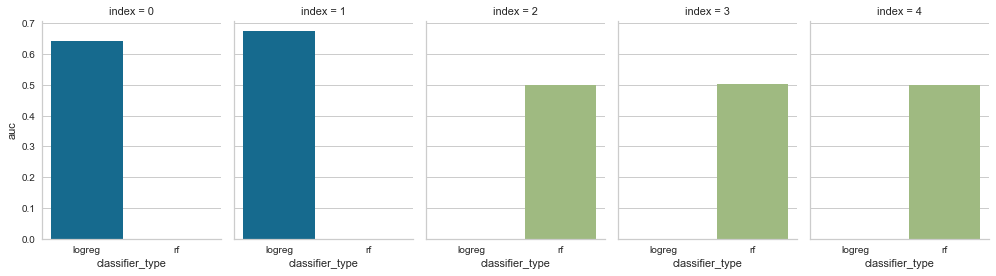

In [352]:
sns.catplot(x="classifier_type", y="auc", col="index",
                data=train_graph, kind="bar",
                height=4, aspect=.7)

In [ ]:
FAIRE COURBE

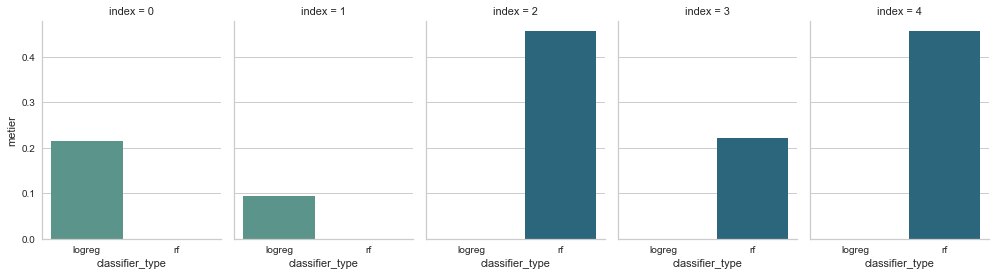

In [354]:
sns.catplot(x="classifier_type", y="metier",
                col="index",orient="v",
                data=train_graph, kind="bar",palette="crest",
                height=4, aspect=.7)

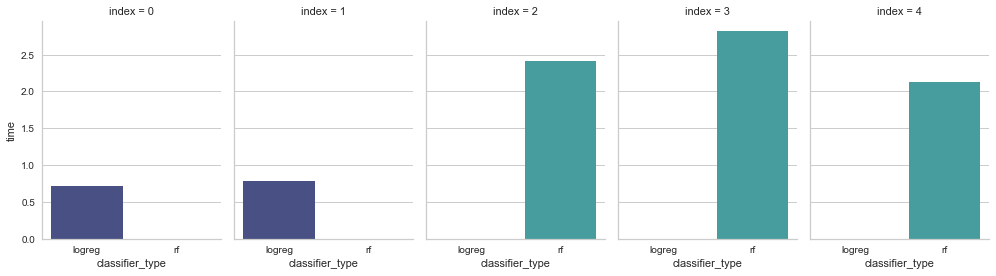

In [355]:
sns.catplot(x="classifier_type", y="time",
                col="index",
                data=train_graph, kind="bar",palette='mako',
                height=4, aspect=.7)

In [359]:
import joblib

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe Roc')
    plt.legend()
    plt.show()


def pipeline_training_metrics(y_prob, y_test):
    # On créé un vecteur de prédiction à partir du vecteur de probabilités
    y_pred = np.where(y_prob > 0.5, 1, 0) 

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(roc_auc)
    #print("false positive rate : ", false_positive_rate)
    #print("true positive rate : ", true_positive_rate)
    x_rate = false_positive_rate
    y_rate = true_positive_rate 

    # This is the ROC curve
    plot_roc_curve(x_rate,y_rate)
    
    CM = metrics.confusion_matrix(y_test, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    metier = (FN*0.9+FP*0.1)/(FN+FP+TN+TP)
    
    print('FULL Métrique Métier : ', metier)

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
    #Matrice de confusion
    conf = metrics.confusion_matrix(y_test, y_pred)
    conf
    sns.heatmap(conf, square=True, annot=True, cbar=False)
            #, xticklabels=list(iris.target_names)
            #, yticklabels=list(iris.target_names))
    plt.xlabel('valeurs prédites')
    plt.ylabel('valeurs réelles')
    plt.title('Matrice de confusion %')
    plt.show()
    
    sns.heatmap(conf/np.sum(conf), annot=True, 
            fmt='.2%', cmap='Blues')
    plt.xlabel('valeurs prédites')
    plt.ylabel('valeurs réelles')
    plt.title('Matrice de confusion %')
    plt.show()
    
    print("\nSur le jeu de test auc : {:.3f}".format(metrics.roc_auc_score(y_test, y_pred)))
    print("\nSur le jeu de test f1_score : {:.3f}".format(metrics.f1_score(y_test, y_pred)))
    print("\nSur le jeu de test precision : {:.3f}".format(metrics.precision_score(y_test, y_pred)))
    print("\nSur le jeu de test recall : {:.3f}".format(metrics.recall_score(y_test, y_pred)))
    #

def result_compare_model(df_best_score_history):
    all_bestscore_history=[]
    i=0
    for item in df_best_score_history.itertuples():
        res = compare_best_model(i, item.classifier_type, item.params, X_train, y_train, X_test, y_test)
        all_bestscore_history.append(res)
        i=i+1
    return pd.DataFrame(all_bestscore_history)

def compare_best_model(i,classifier_type, params, X_train, y_train, X_test, y_test):
   ## Correction des paramètres identiques
    if 'max_depthg' in params:
        params["max_depth"]=int(params["max_depthg"])
        params["n_estimators"]=int(params["n_estimatorsg"])
        del params["max_depthg"]
        del params["n_estimatorsg"]
    
    print(params)
    if classifier_type == 'rf':
        clf = RandomForestClassifier(**params)
    elif (classifier_type == 'logreg'):
        clf = LogisticRegression(**params)
    else:
        return 0
    
    t0 = time.time()
             
    clf.fit(X_train, y_train)
    
    y_prob = clf.predict_proba(X_test)[:,1] 
    
    # On créé un vecteur de prédiction à partir du vecteur de probabilités
    y_pred = np.where(y_prob > 0.5, 1, 0) 
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    metier_c=fmetric_metier(y_test, y_pred)
    pipeline_training_metrics(y_pred, y_test)
    time_res=time.time() - t0
    return {'classifier_type':classifier_type, 'score':roc_auc,'metier':metier_c,'time': time_res, 'params':params}

{'C': 0.649318177342981, 'penalty': 'l1', 'solver': 'liblinear'}
FULL Métrique Métier :  0.0888655462184874
0.6862978858687014


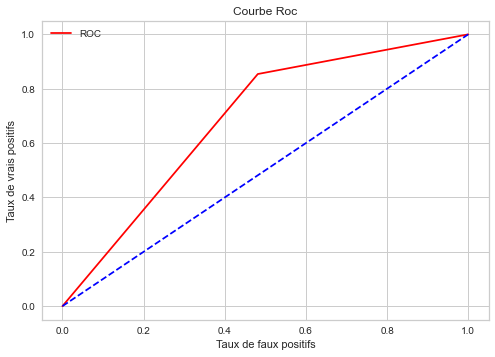

FULL Métrique Métier :  0.0888655462184874
Mean Absolute Error: 0.3172268907563025
Mean Squared Error: 0.3172268907563025
Root Mean Squared Error: 0.5632289860760918


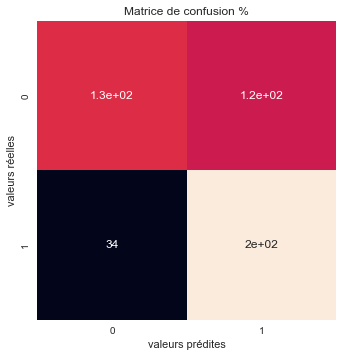

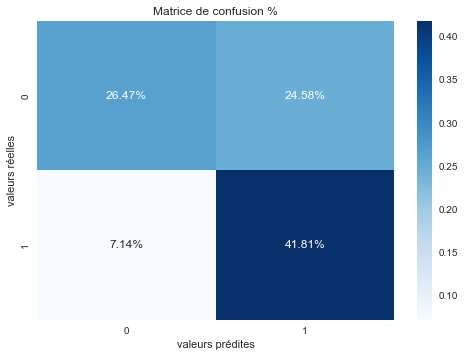


Sur le jeu de test auc : 0.686

Sur le jeu de test f1_score : 0.725

Sur le jeu de test precision : 0.630

Sur le jeu de test recall : 0.854
{'C': 0.7666104110217109, 'penalty': 'l2', 'solver': 'liblinear'}
FULL Métrique Métier :  0.08907563025210086
0.684240272699977


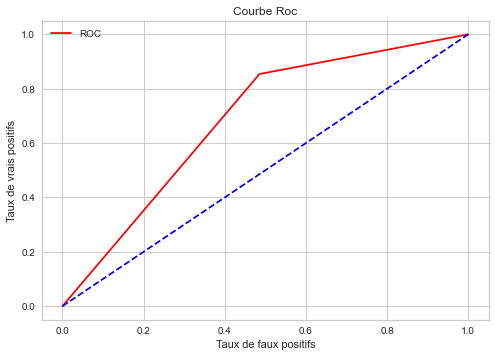

FULL Métrique Métier :  0.08907563025210086
Mean Absolute Error: 0.31932773109243695
Mean Squared Error: 0.31932773109243695
Root Mean Squared Error: 0.565090905158132


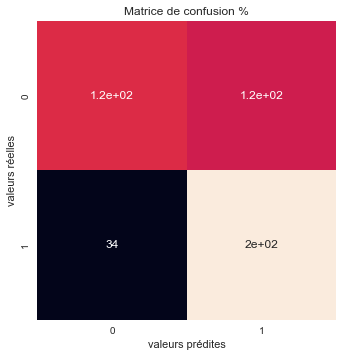

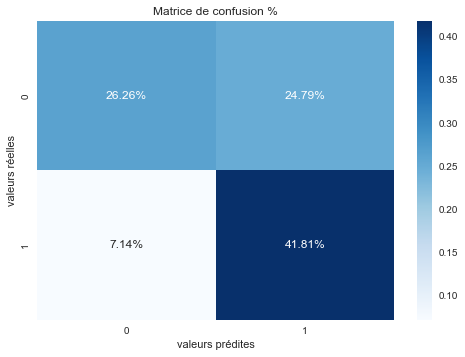


Sur le jeu de test auc : 0.684

Sur le jeu de test f1_score : 0.724

Sur le jeu de test precision : 0.628

Sur le jeu de test recall : 0.854
{'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 0.19691113087655326, 'min_samples_split': 9, 'n_estimators': 162}
FULL Métrique Métier :  0.10987394957983194
0.6933803140288597


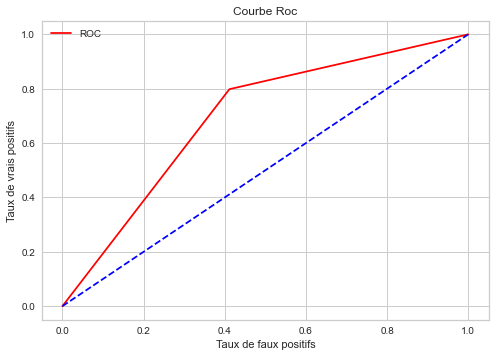

FULL Métrique Métier :  0.10987394957983194
Mean Absolute Error: 0.3088235294117647
Mean Squared Error: 0.3088235294117647
Root Mean Squared Error: 0.5557189302262113


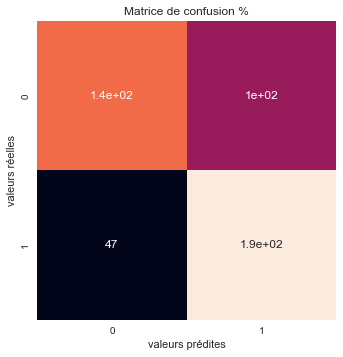

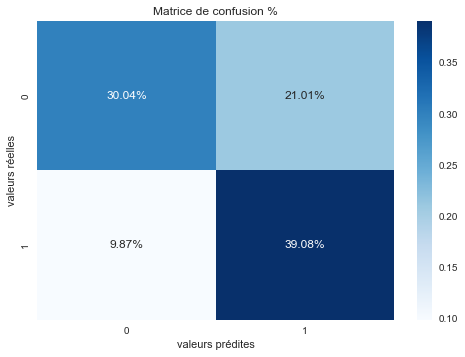


Sur le jeu de test auc : 0.693

Sur le jeu de test f1_score : 0.717

Sur le jeu de test precision : 0.650

Sur le jeu de test recall : 0.798
{'max_depth': 6, 'max_features': 1, 'min_samples_leaf': 0.2491530649081098, 'min_samples_split': 9, 'n_estimators': 262}
FULL Métrique Métier :  0.1319327731092437
0.7065472721171339


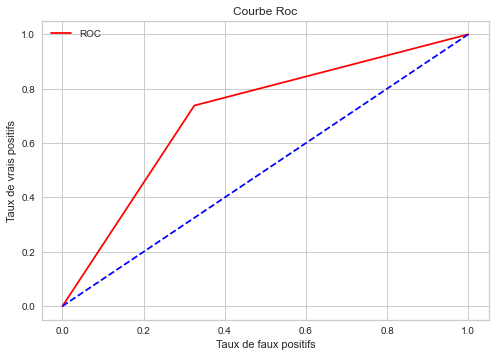

FULL Métrique Métier :  0.1319327731092437
Mean Absolute Error: 0.29411764705882354
Mean Squared Error: 0.29411764705882354
Root Mean Squared Error: 0.5423261445466404


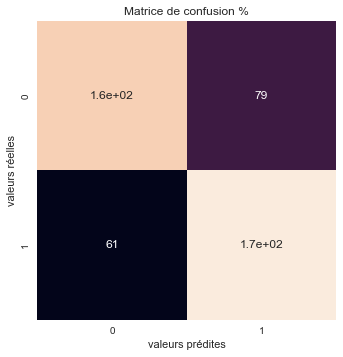

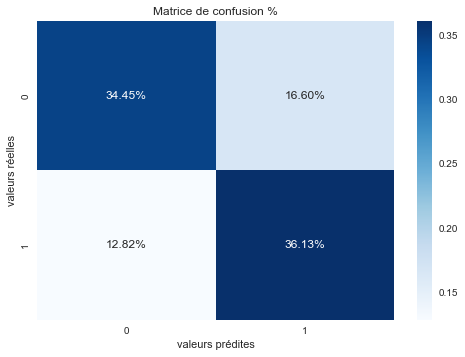


Sur le jeu de test auc : 0.707

Sur le jeu de test f1_score : 0.711

Sur le jeu de test precision : 0.685

Sur le jeu de test recall : 0.738
{'max_depth': 4, 'max_features': 2, 'min_samples_leaf': 0.2969251354284949, 'min_samples_split': 11, 'n_estimators': 209}
FULL Métrique Métier :  0.1647058823529412
0.6966389374591568


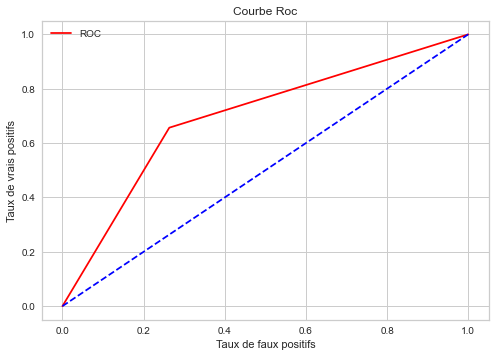

FULL Métrique Métier :  0.1647058823529412
Mean Absolute Error: 0.3025210084033613
Mean Squared Error: 0.3025210084033613
Root Mean Squared Error: 0.5500190982169267


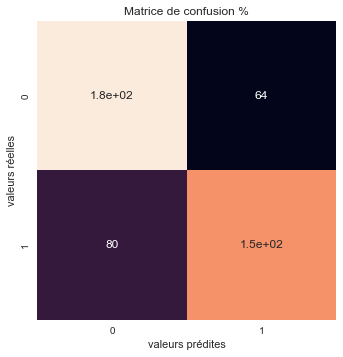

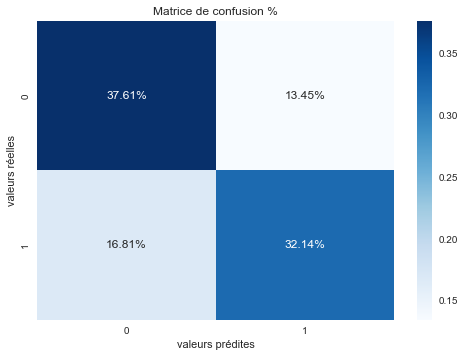


Sur le jeu de test auc : 0.697

Sur le jeu de test f1_score : 0.680

Sur le jeu de test precision : 0.705

Sur le jeu de test recall : 0.657


In [360]:
final_result=result_compare_model(df_metrics_history)

In [363]:
final_result = final_result.reset_index()

In [364]:

data=final_result.copy()



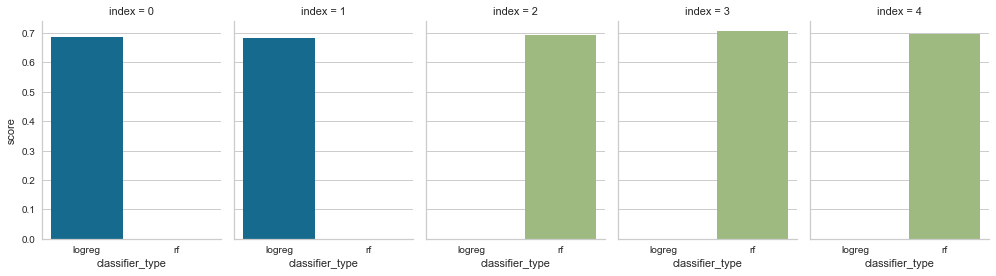

In [366]:
sns.catplot(x="classifier_type", y="score",
                col="index",
                data=data, kind="bar",
                height=4, aspect=.7)

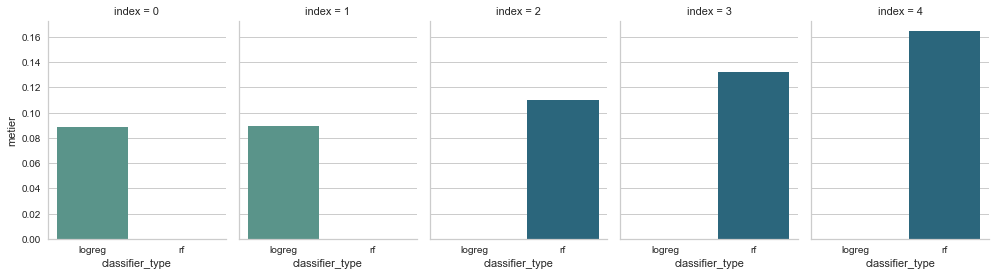

In [368]:
sns.catplot(x="classifier_type", y="metier",
                col="index",
                data=data, kind="bar",palette="crest",
                height=4, aspect=.7)

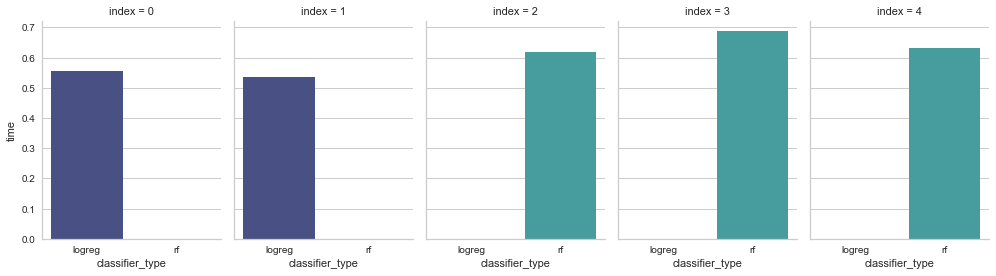

In [370]:
sns.catplot(x="classifier_type", y="time",
                col="index",
                data=data, kind="bar",palette="mako",
                height=4, aspect=.7)

In [371]:
final_result

,level_0,index,classifier_type,score,metier,time,params
0,0,0,logreg,0.686298,0.088866,0.555511,"{'C': 0.649318177342981, 'penalty': 'l1', 'sol..."
1,1,1,logreg,0.684240,0.089076,0.534559,"{'C': 0.7666104110217109, 'penalty': 'l2', 'so..."
2,2,2,rf,0.693380,0.109874,0.619339,"{'max_depth': 8, 'max_features': 2, 'min_sampl..."
3,3,3,rf,0.706547,0.131933,0.687737,"{'max_depth': 6, 'max_features': 1, 'min_sampl..."
4,4,4,rf,0.696639,0.164706,0.631312,"{'max_depth': 4, 'max_features': 2, 'min_sampl..."


## Approche Modèle sur mesure simple : Concepteur / Designer - service Azure Machine Learning